### This notebook will be used to analyze the results collected from the website developed, with the game to guess player's positions

##### First, we'll read the csvs

In [2]:
import pandas as pd
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
predictions = pd.read_csv('NBA - Predictions.csv', index_col=0)
predictions.drop(columns=["Createdat"], inplace=True)
feedbacks = pd.read_csv('NBA - UserFeedbacks.csv')
tutorial = pd.read_csv('NBA - Tutorial.csv', index_col=0)
results = pd.read_csv('NBA - Results.csv', index_col=0)
results.drop(columns=["Createdat"], inplace=True)

#### Now, let's join these dfs based on the user

In [4]:
# Rename columns for consistency
predictions.rename(columns={'User': 'User', 'Userattempt': 'Attempt'}, inplace=True)
results.rename(columns={'User': 'User', 'Attempt': 'Attempt'}, inplace=True)
tutorial.rename(columns={'User': 'User', 'Att': 'Attempt'}, inplace=True)

# Convert 'Attempt' column to numeric, handling errors
predictions['Attempt'] = pd.to_numeric(predictions['Attempt'], errors='coerce')
results['Attempt'] = pd.to_numeric(results['Attempt'], errors='coerce')
tutorial['Attempt'] = pd.to_numeric(tutorial['Attempt'], errors='coerce')

# Merge predictions and results
merged_df = pd.merge(predictions, results, on=['User', 'Attempt'], how='left')

# Merge with tutorial
final_df = pd.merge(merged_df, tutorial, on=['User', 'Attempt'], how='left')

In [6]:
def extract_player_info(player_string):
    try:
        player, position_season = player_string.split('-')
        position, season = position_season.split('(')
        season = season[:-1]  # Remove the closing parenthesis
        return player, position, season
    except:
        return None, None, None


In [7]:
final_df[['Player', 'Real Position', 'Season']] = final_df['Player'].apply(lambda x: pd.Series(extract_player_info(x)))

final_df.dropna(axis=0, how='any', inplace=True)
final_df.reset_index(drop=True, inplace=True)

### Relation between position and efficacy for each user

Entropy of Guesses per Real Position:
Real Position
C     1.210446
PF    1.962333
PG    1.574857
SF    1.997048
SG    1.913553
Name: count, dtype: float64


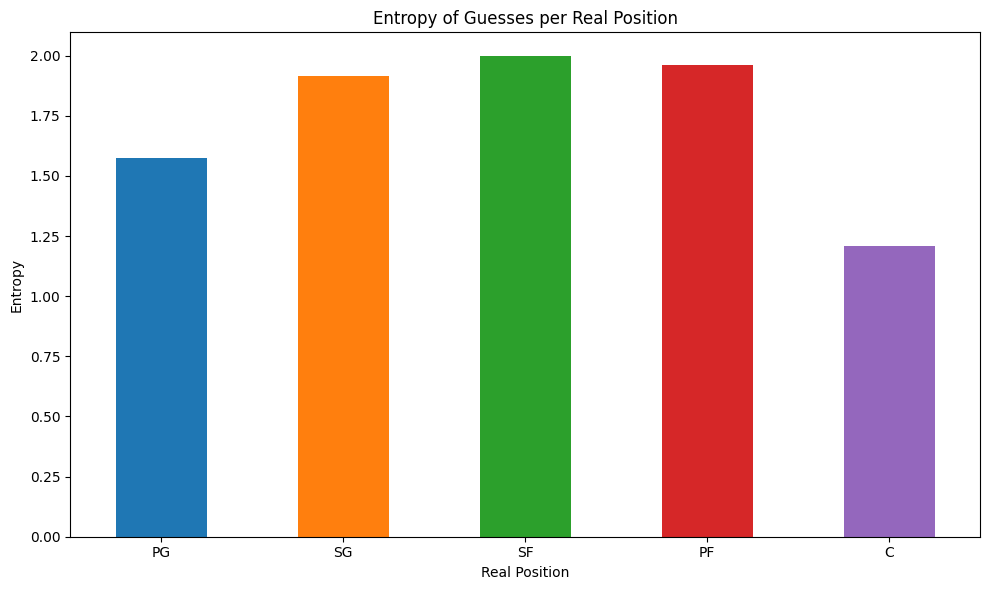

In [10]:
fdf = final_df[final_df['Passed'] == True]
guess_distribution_by_pos = fdf.groupby('Real Position')['Position'].value_counts()

# Normalize the counts to get probabilities for each real position's guesses.
guess_probabilities_by_pos = guess_distribution_by_pos.groupby(level=0).apply(lambda x: x / x.sum())

# Calculate the entropy for each real position's guess distribution.
position_entropy = guess_probabilities_by_pos.groupby(level=0).apply(lambda p: entropy(p, base=2))

print("Entropy of Guesses per Real Position:")
print(position_entropy)

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Reindex the Series to match the desired order
position_entropy = position_entropy.reindex(desired_order)

# Plotting the entropy for better visualization
plt.figure(figsize=(10, 6))
position_entropy.plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4'])
plt.xlabel('Real Position')
plt.ylabel('Entropy')
plt.title('Entropy of Guesses per Real Position')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('entropy_per_position_human.png')
plt.show()


#### Repeat grouping in intervals of 5

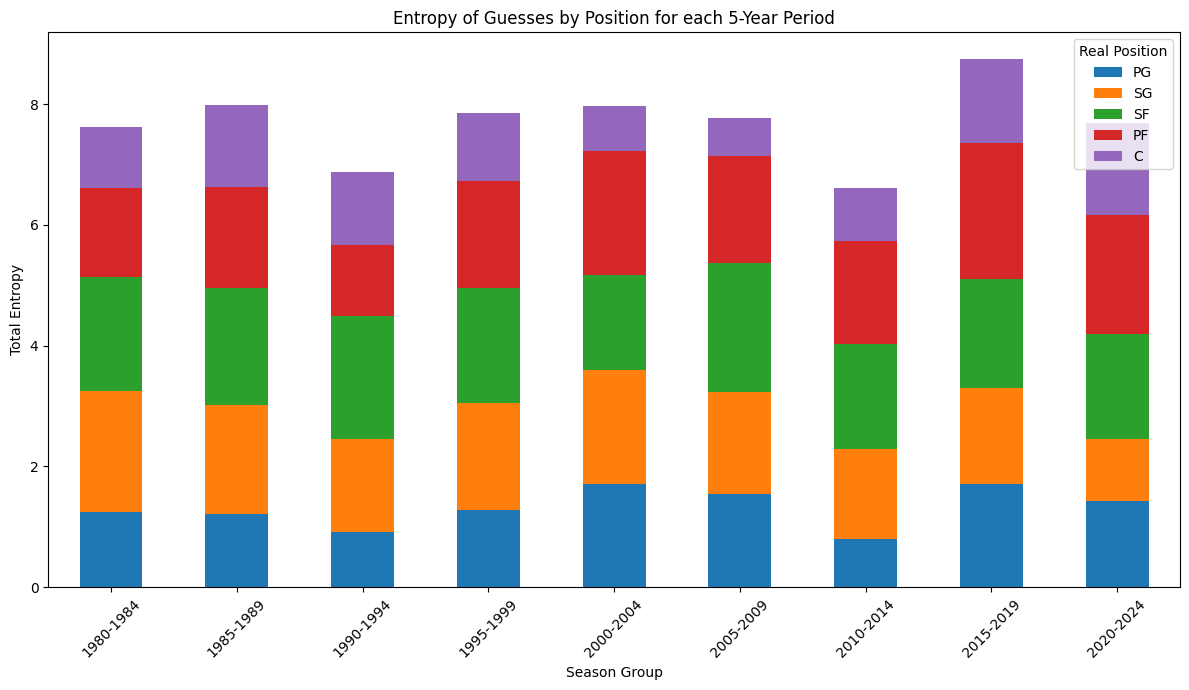

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy

# Assuming final_df is already loaded and 'Season' column exists

# Convert 'Season' to numeric if it's not already
fdf = final_df[final_df['Passed']].copy()
fdf['Season'] = pd.to_numeric(fdf['Season'], errors='coerce')

# Define a function to group seasons into 5-year periods
def group_seasons(season):
    # Handle potential NaN values
    if pd.isna(season):
        return None
    return f'{int(season // 5 * 5)}-{int(season // 5 * 5 + 4)}'

# Apply the grouping function to create a new 'Season Group' column
fdf['Season Group'] = fdf['Season'].apply(group_seasons)
fdf.dropna(subset=['Season Group'], inplace=True)


# Group by season group and real position, then calculate entropy
guess_distribution = fdf.groupby(['Season Group', 'Real Position'])['Position'].value_counts()
guess_probabilities = guess_distribution.groupby(level=[0, 1]).apply(lambda x: x / x.sum())
entropy_by_pos_season = guess_probabilities.groupby(level=[0, 1]).apply(lambda p: entropy(p, base=2))

# Unstack the series to get a DataFrame suitable for a stacked bar chart
entropy_df = entropy_by_pos_season.unstack(level='Real Position')

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']
entropy_df = entropy_df.reindex(columns=desired_order)


# Plot the results
entropy_df.plot(kind='bar', stacked=True, figsize=(12, 7))

plt.xlabel('Season Group')
plt.ylabel('Total Entropy')
plt.title('Entropy of Guesses by Position for each 5-Year Period')
plt.xticks(rotation=45)
plt.legend(title='Real Position')
plt.tight_layout()
plt.show()


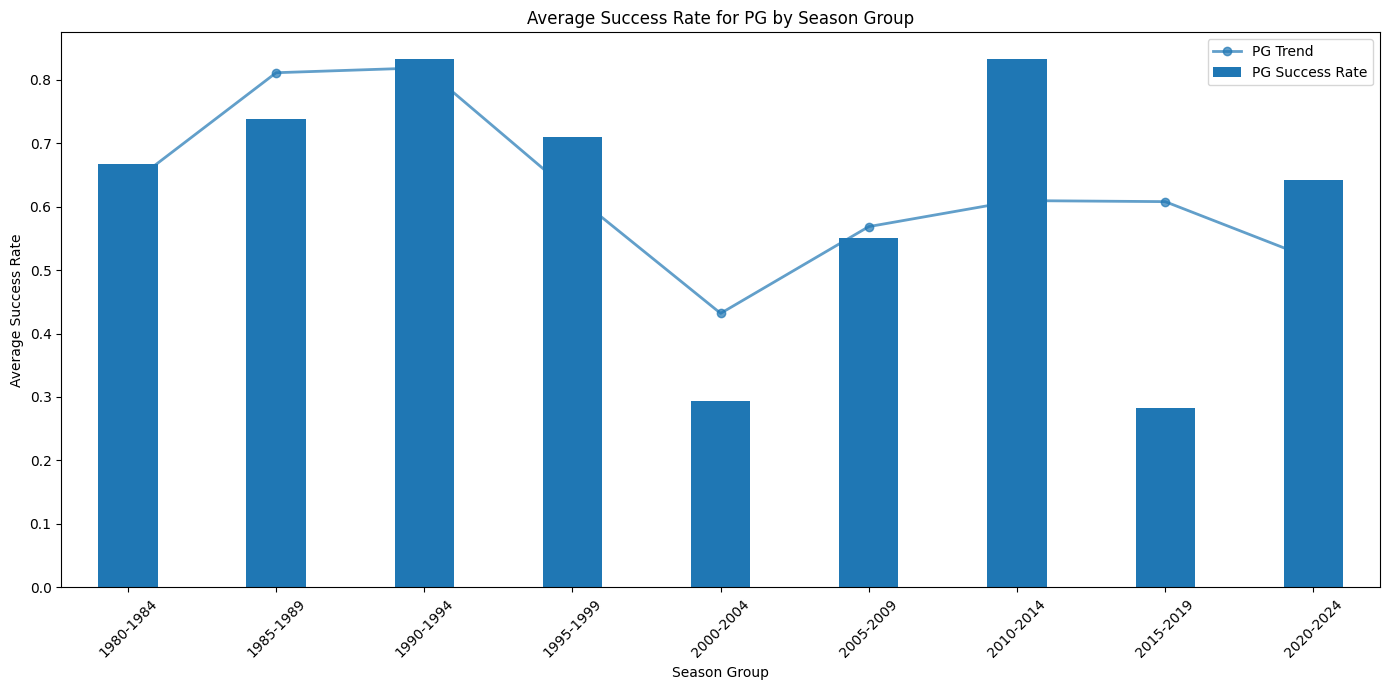

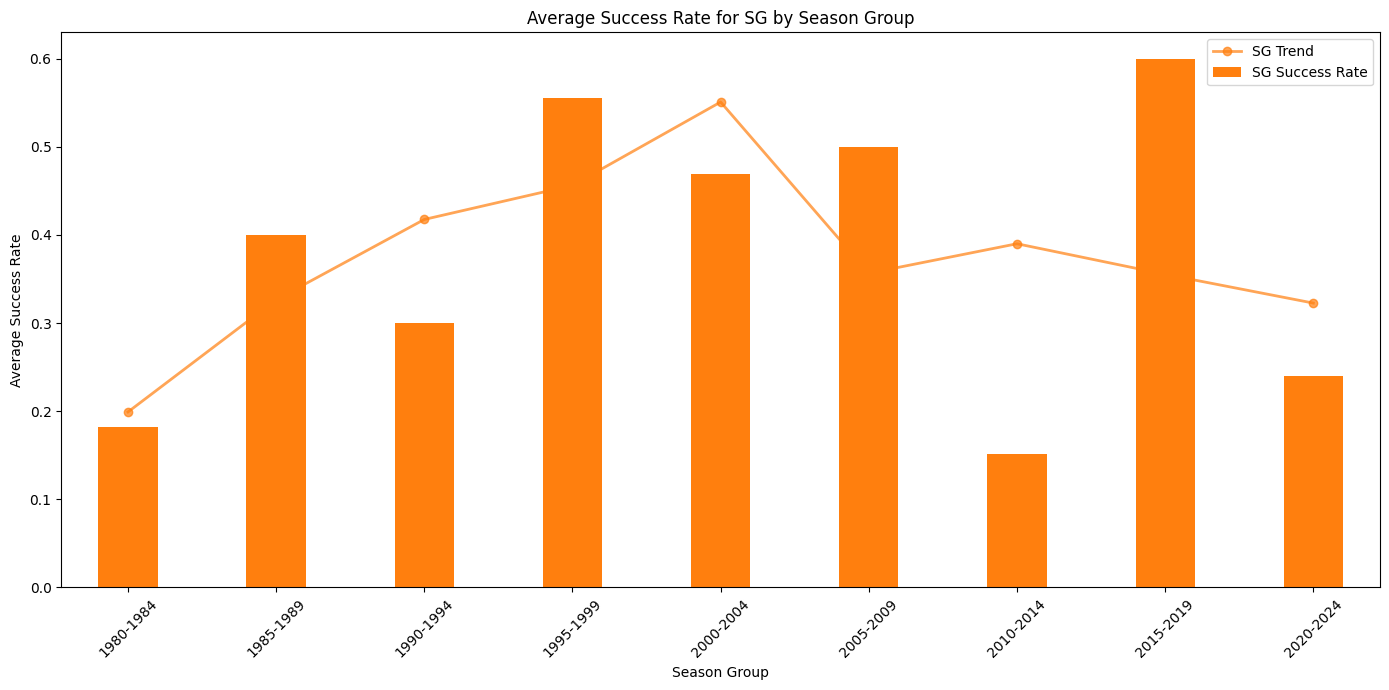

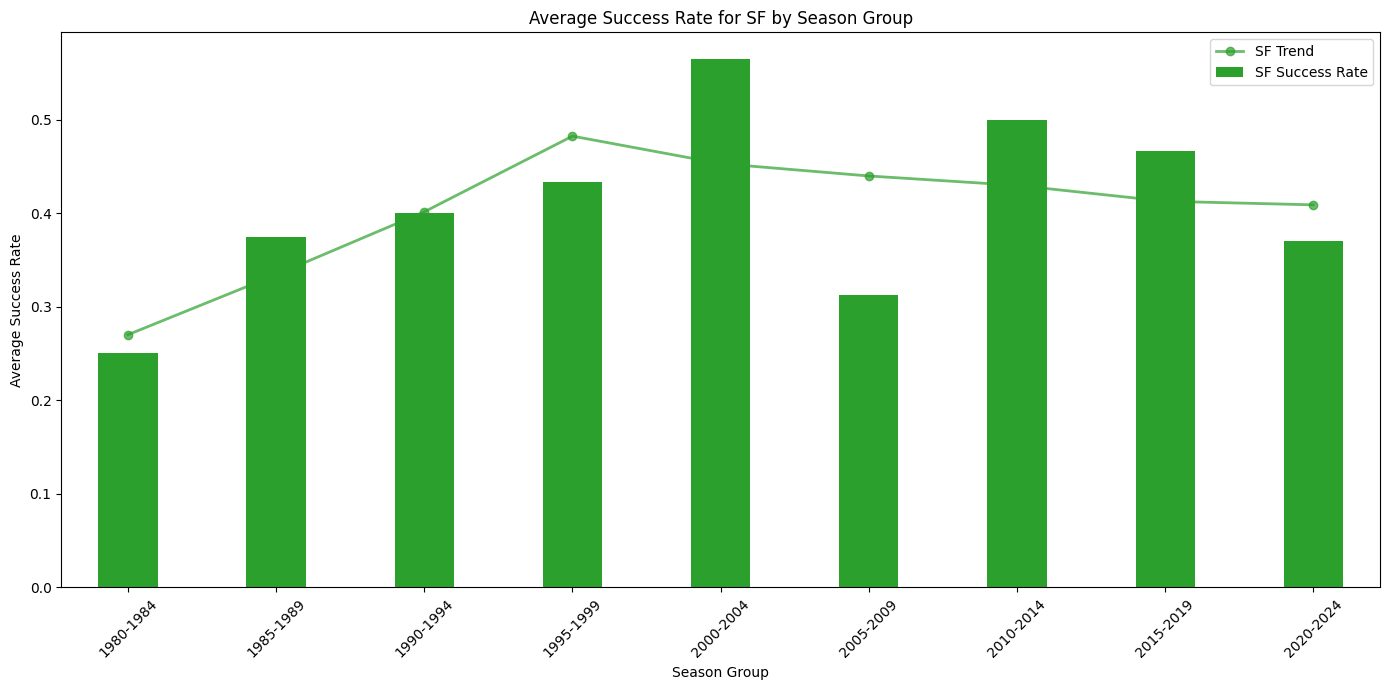

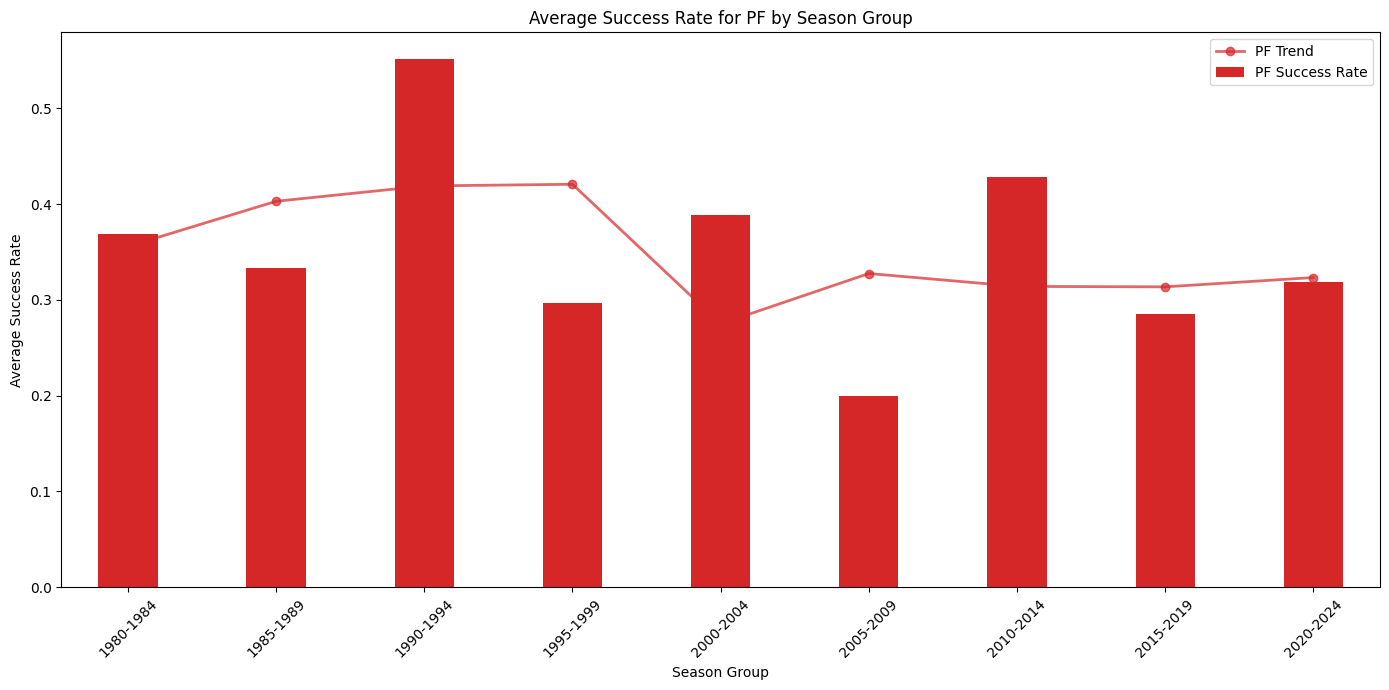

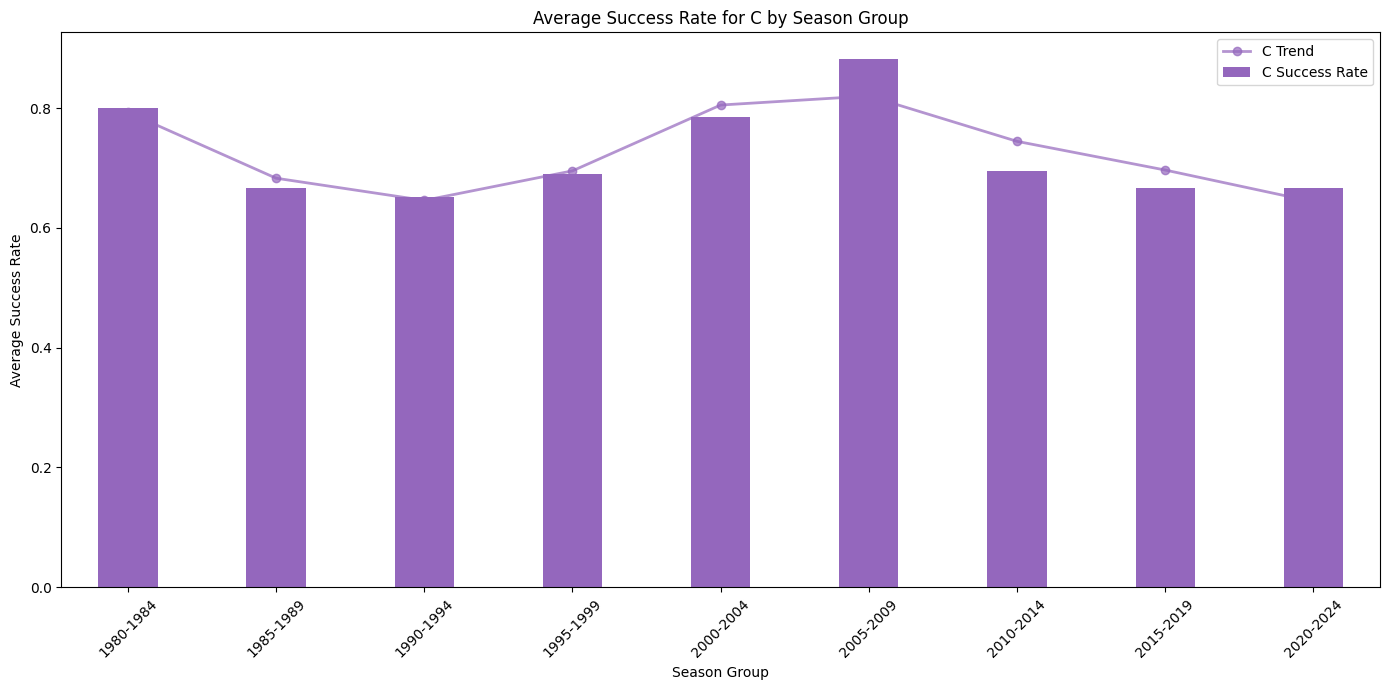

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import entropy

# Assuming final_df is already loaded and 'Season' and 'Real Position' columns exist

# Convert 'Season' to numeric if it's not already
final_df['Season'] = pd.to_numeric(final_df['Season'], errors='coerce')

# Define a function to group seasons into 5-year periods
def group_seasons(season):
    if pd.isna(season):
        return None
    return f'{int(season // 5 * 5)}-{int(season // 5 * 5 + 4)}'

# Apply the grouping function to create a new 'Season Group' column
fdf = final_df.copy()
fdf['Season Group'] = fdf['Season'].apply(group_seasons)
fdf.dropna(subset=['Season Group'], inplace=True)


fdf = fdf[fdf['Passed']]

# Define the desired order of positions
desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Group by season group and real position, then calculate entropy
guess_distribution = fdf.groupby(['Season Group', 'Real Position'])['Position'].value_counts()
guess_probabilities = guess_distribution.groupby(level=[0, 1]).apply(lambda x: x / x.sum())
entropy_by_pos_season = guess_probabilities.groupby(level=[0, 1]).apply(lambda p: entropy(p, base=2))

# Unstack the results to create a table with positions as columns and season groups as rows
entropy_table = entropy_by_pos_season.unstack(level='Real Position')

# Reindex the columns to match the desired order of positions
entropy_table = entropy_table.reindex(columns=desired_order)

# Plot a separate chart for each position
for position in desired_order:
    plt.figure(figsize=(14, 7))
    
    # Plot the bar chart for the individual position, with a lower zorder
    ax = entropy_table[position].plot(kind='bar', width=0.4, label=f'{position} Entropy', color=f'C{desired_order.index(position)}', zorder=1)
    
    # Calculate and overlay the Savitzky-Golay filter trend line, with a higher zorder
    # Ensure there are enough data points for the filter
    if len(entropy_table[position].dropna()) > 5:
        smoothed_trend = savgol_filter(entropy_table[position].dropna(), window_length=5, polyorder=2)
        ax.plot(entropy_table[position].dropna().index, smoothed_trend, linestyle='-', marker='o', linewidth=2, label=f'{position} Trend', color=f'C{desired_order.index(position)}', alpha=0.7, zorder=2)

    plt.xlabel('Season Group')
    plt.ylabel('Entropy')
    plt.title(f'Entropy of Guesses for {position} by Season Group')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
